#### Treatment Comparison
Compare barcoded subpopulations of idling and untreated (control) SKMEL5 cells by their cell-cell distance in PCA space

In [1]:
# load files and packages
from fcc_utils import *
from fcc_DRs import *

%matplotlib inline

Using TensorFlow backend.


In [34]:
# reload functions when editing file
import sys
del sys.modules['fcc_DRs']
from fcc_DRs import *

Read in data files and associate barcodes with RNA counts

In [35]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 32.5 s, sys: 6.7 s, total: 39.2 s
Wall time: 41.4 s


Check out shape of counts matrices and barcode abundance

Untreated control: (2886, 25370)
Treated idling cells: (3524, 25370)


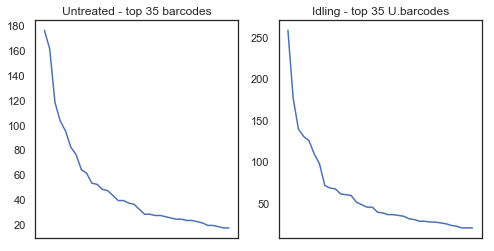

In [133]:
print('Untreated control: ' + str(U.data.shape))
print('Treated idling cells: ' + str(I.data.shape))

top35 = [x for x in range(1,36)]
plt.figure(figsize=(8,4))

plt.subplot(121)
U.barcode_counts(IDs=U.top_barcodes(top35)).plot()
plt.title('Untreated - top 35 barcodes')

plt.subplot(122)
I.barcode_counts(IDs=I.top_barcodes(top35)).plot()
plt.title('Idling - top 35 U.barcodes')

plt.show()

Using top 35 barcodes in __Untreated__ set, look at abundance in __Idling__ set

In [70]:
min(I.barcode_counts(IDs=U.top_barcodes(top35)))

10

So, of the top 35 codes in the Untreated set, the lowest counts in the Idling set is 10, which is our cutoff.

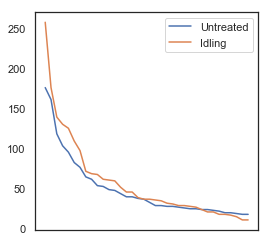

In [128]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top35)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top35)).plot(label='Idling', legend=True)
plt.show()

Perform PCA on each dataset and plot selected barcodes

In [75]:
# first get list of codes to use throughout the rest of analysis
selected_codes = U.top_barcodes(top35)

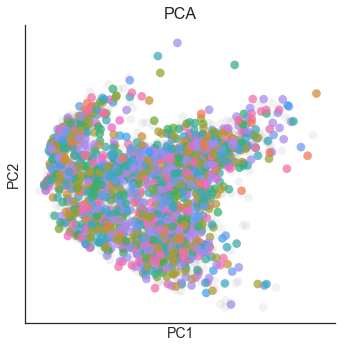

CPU times: user 14.7 s, sys: 2.68 s, total: 17.4 s
Wall time: 12.7 s


In [76]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)
U_PCA.plot_barcodes(ranks=selected_codes)

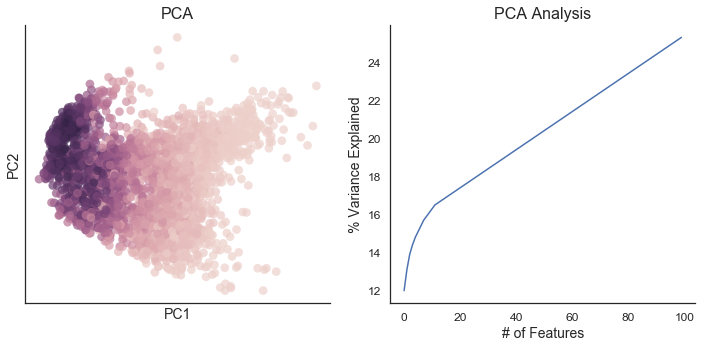

In [129]:
U_PCA.plot()

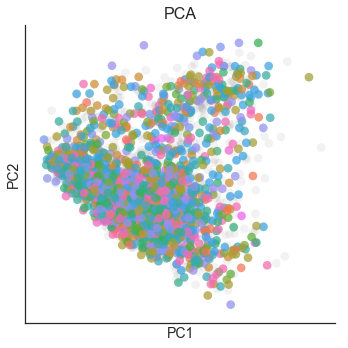

CPU times: user 17.3 s, sys: 3.86 s, total: 21.2 s
Wall time: 15.4 s


In [77]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)
I_PCA.plot_barcodes(ranks=selected_codes)

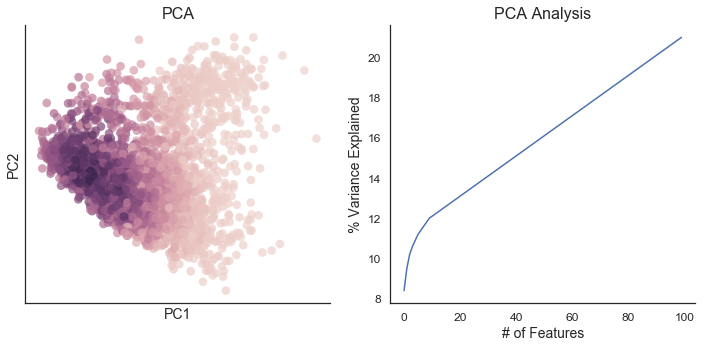

In [130]:
I_PCA.plot()

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

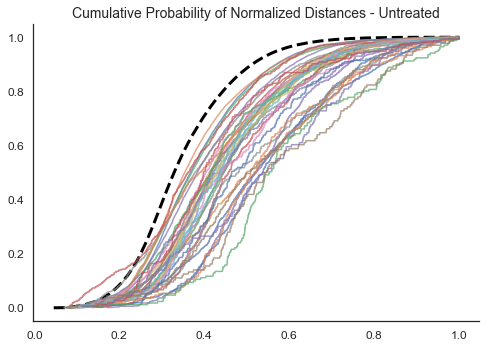

CPU times: user 56.1 s, sys: 2.75 s, total: 58.9 s
Wall time: 59.7 s


In [131]:
%%time
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

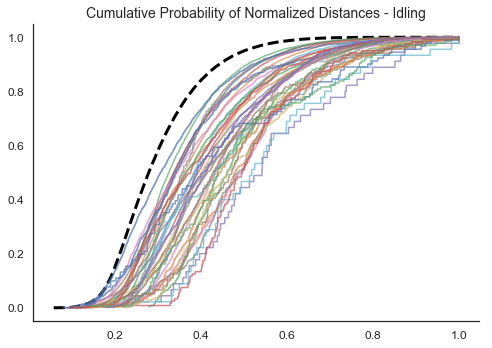

CPU times: user 1min 25s, sys: 3.7 s, total: 1min 29s
Wall time: 1min 32s


In [132]:
%%time
pre = I_PCA.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_PCA.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

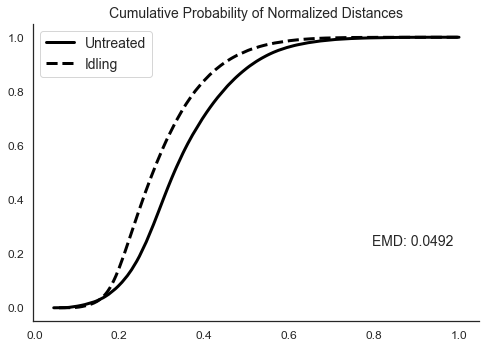

CPU times: user 10.9 s, sys: 2.07 s, total: 13 s
Wall time: 12.8 s


In [138]:
%%time
pre = U_PCA.distance_matrix(ranks='all') # null is whole untreated population
post = I_PCA.distance_matrix(ranks='all')

pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

# take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
post_flat = post[np.triu_indices(post.shape[1],1)]
# normalize flattened distances within each set for fair comparison of probability distributions
post_flat_norm = (post_flat/post_flat.max())

# calculate EMD for the distance matrices
EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
# Kullback Leibler divergence
# add very small number to avoid dividing by zero
KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram(pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum(pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label='Untreated', linestyle='solid', linewidth=3, color='black')

post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
post_cdf = np.cumsum(post_counts) 
plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label='Idling', linestyle='dashed', linewidth=3, color='black')

plt.title('Cumulative Probability of Normalized Distances', fontsize=14)
plt.figtext(0.75, 0.3, 'EMD: {}'.format(round(EMD,4)), fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

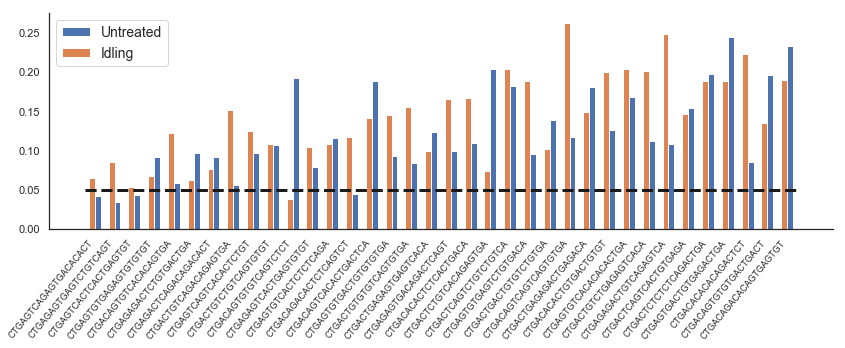

In [160]:
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.3, label='Untreated')
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.3, label='Idling')
plt.hlines(y=0.0492, xmin=-0.5, xmax=len(I_out.code)-0.5, linestyle='dashed', linewidth=3)
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()